In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, jarque_bera
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
from scipy import stats

In [2]:
housing = fetch_california_housing()
X, y = housing.data, housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

**Understanding Coefficients**

In [3]:
def interpret_model(model, feature_names, x_scaled):
    coefficients = model.coef_
    intercept = model.intercept_
    
    interpretation = pd.DataFrame({
        'Feature' : feature_names,
        'Coefficients' : coefficients,
        'Abs_Coefficients' : np.abs(coefficients)
    }).sort_values('Abs_Coefficients', ascending=False)
    
    print("Model Interpretation:")
    print(f"Intercept: {intercept:.3f}")
    print("\nFeature Coefficients (sorted by importance):")
    print(interpretation)
    
    # Interpretation
    print("\nInterpretation:")
    print("Positive coefficient: Feature increases target")
    print("Negative coefficient: Feature decreases target")
    print("Larger absolute value: Stronger effect")
    
    return interpretation


housing = fetch_california_housing()
feature_names = housing.feature_names
interpretation = interpret_model(model, feature_names, X_train_scaled)

Model Interpretation:
Intercept: 2.072

Feature Coefficients (sorted by importance):
      Feature  Coefficients  Abs_Coefficients
6    Latitude     -0.896929          0.896929
7   Longitude     -0.869842          0.869842
0      MedInc      0.854383          0.854383
3   AveBedrms      0.339259          0.339259
2    AveRooms     -0.294410          0.294410
1    HouseAge      0.122546          0.122546
5    AveOccup     -0.040829          0.040829
4  Population     -0.002308          0.002308

Interpretation:
Positive coefficient: Feature increases target
Negative coefficient: Feature decreases target
Larger absolute value: Stronger effect


In [5]:
def confidence_intervals(model, x, y, alpha=0.05):
    n = len(y)
    p = x.shape[1]
    
    y_pred = model.predict(x)
    residuals = y - y_pred
    mse = np.mean(residuals**2)
    
    # Standard errors
    x_with_intercept = np.column_stack([np.ones(n), x])
    cov_matrix = mse * np.linalg.inv(x_with_intercept.T @ x_with_intercept)
    std_errors = np.sqrt(np.diag(cov_matrix))
    
    # t-statistic
    t_value = stats.t.ppf(1 - alpha/2, n-p-1)
    
     # Confidence intervals
    coef_with_intercept = np.concatenate([[model.intercept_], model.coef_])
    lower = coef_with_intercept - t_value * std_errors
    upper = coef_with_intercept + t_value * std_errors
    return lower, upper, std_errors

lower, upper, std_errors = confidence_intervals(model, X_train_scaled, y_train)

print("Coefficient Confidence Intervals (95%):")
print(f"Intercept: [{lower[0]:.3f}, {upper[0]:.3f}]")
for i, name in enumerate(feature_names):
    print(f"{name}: [{lower[i+1]:.3f}, {upper[i+1]:.3f}]")

Coefficient Confidence Intervals (95%):
Intercept: [2.061, 2.083]
MedInc: [0.837, 0.872]
HouseAge: [0.110, 0.135]
AveRooms: [-0.325, -0.264]
AveBedrms: [0.311, 0.367]
Population: [-0.014, 0.009]
AveOccup: [-0.052, -0.030]
Latitude: [-0.930, -0.864]
Longitude: [-0.903, -0.837]


In [ ]:
from sklearn.model_selection import GridSearchCV

# Ridge
ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

ridge_grid = GridSearchCV(
    Ridge(),
    ridge_params,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

ridge_grid.fit(X_train_scaled, y_train)

print("Best Ridge Parameters:")
print(f"  Alpha: {ridge_grid.best_params_['alpha']}")
print(f"  Best CV Score (RMSE): {np.sqrt(-ridge_grid.best_score_):.3f}")

# Lasso
lasso_params = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
}

lasso_grid = GridSearchCV(
    Lasso(max_iter=10000),
    lasso_params,
    cv=5,
    scoring='neg_mean_squared_error'
)

lasso_grid.fit(X_train_scaled, y_train)

print("\nBest Lasso Parameters:")
print(f"  Alpha: {lasso_grid.best_params_['alpha']}")
print(f"  Best CV Score (RMSE): {np.sqrt(-lasso_grid.best_score_):.3f}")

# Elastic Net
elastic_params = {
    'alpha': [0.001, 0.01, 0.1, 1.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

elastic_grid = GridSearchCV(
    ElasticNet(max_iter=10000),
    elastic_params,
    cv=5,
    scoring='neg_mean_squared_error'
)

elastic_grid.fit(X_train_scaled, y_train)

print("\nBest Elastic Net Parameters:")
print(f"  Alpha: {elastic_grid.best_params_['alpha']}")
print(f"  L1 Ratio: {elastic_grid.best_params_['l1_ratio']}")
print(f"  Best CV Score (RMSE): {np.sqrt(-elastic_grid.best_score_):.3f}")

Best Ridge Parameters:
  Alpha: 0.1
  Best CV Score (RMSE): 0.721

Best Lasso Parameters:
  Alpha: 0.001
  Best CV Score (RMSE): 0.721

Best Elastic Net Parameters:
  Alpha: 0.001
  L1 Ratio: 0.9
  Best CV Score (RMSE): 0.721


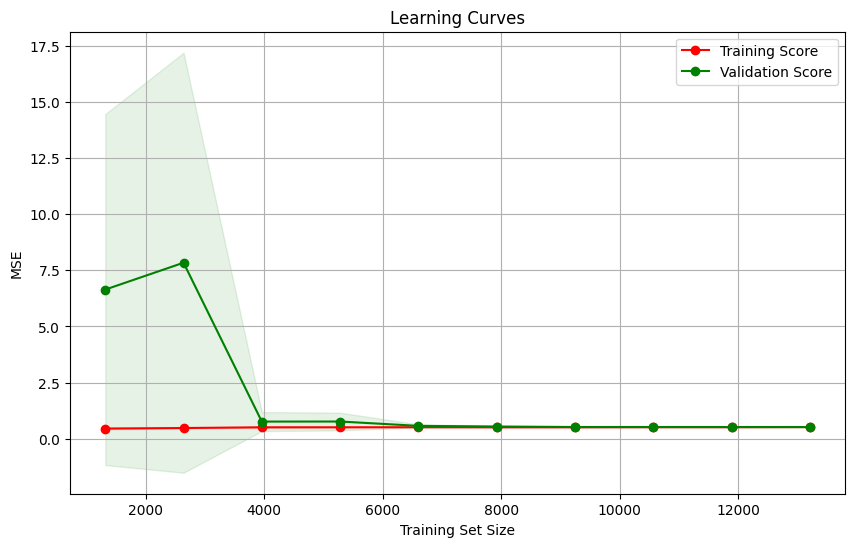

In [9]:
from sklearn.model_selection import learning_curve

def plot_learning_curves(model, X, y):
    """
    Plot learning curves to diagnose bias/variance
    """
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_mean_squared_error'
    )
    
    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    val_scores_std = val_scores.std(axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation Score')
    plt.xlabel('Training Set Size')
    plt.ylabel('MSE')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curves(model, X_train_scaled, y_train)